# Derive the orbit of the AB binary
New information here is an additional velocity for BaBb from the CO detection.

In [1]:
import numpy as np
import scipy.optimize
import emcee
import corner
import dd.dynamics
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
# get data
date, pa, e_pa, sep, e_sep = np.genfromtxt('ABorb.txt', comments='#', unpack=True)

# add 90 to avoid measurements wrapping near N
pa += 90
pa = (pa + 360) % 360

# unknown uncertainties
e_pa[e_pa==0] = 1.0    # this is a rough guess, but the residuals look reasonable
e_pa[date<1950] = 2    # do this based on scatter in residuals
e_sep[e_sep==0] = 0.1  # as above

# modern uncertainties, 0.5deg pa uncertainty from Tokovinin+14
e_pa[e_pa<0.5] = 0.5

In [3]:
# function to return model at these times
def orbit_pos(p):
    period = (p[0]*44.9)**1.5 / np.sqrt(1.3+1.28)
    x, y, _ = dd.dynamics.sky_orbit(p[0], p[1], p[2], p[3], p[4], date, t=p[5], period=period)
    mod_pa = np.rad2deg(np.arctan2(y,x)) - 90 # back to East of North
    mod_pa = (mod_pa + 90 + 360) % 360
    mod_sep = np.sqrt(x*x + y*y)
    return mod_pa, mod_sep

def lnprior(p):
    '''Prior on mass of A, assume uncertainty of 0.15 M_Sun.'''
    return -0.5 * ((p[6]-1.3) / 0.15)**2

def lnlike(p, verb=False):
    for x,r in zip(p,ranges):
        if x < r[0] or x > r[1]:
            return -np.inf

    # get RV, need velocity of B relative to A
    period = (p[0]*44.9)**1.5 / np.sqrt(p[6]+1.28)
    dyr = (np.array([1991.96, 2017.874]) - period) % p[5]   # time since last pericenter passage
    m = dyr / p[5] * np.pi*2                                # mean anomaly (radians)
    f = np.rad2deg( dd.dynamics.convmf(m, p[1]) )           # true anomaly (degrees)
    if verb:
        print('period:{}'.format(period))
        print('true anomaly:{}'.format(f))
    
    x, y, z, vx, vy, vz = dd.dynamics.el2xv(p[0]*44.9, p[1], p[2], p[3], p[4]+90, f,
                                            degrees=True, au=True, mstar=p[6]+1.28)

    # A-B delta RV from Torres is 7.02,, we have B-A (with A=0) but vz is -ve w.r.t. RV
    drv1 = vz[0]/1e3 - 7.02
    # B delta RV between dates above, -ve in RV, so +ve in z
    drv2 = (vz[0] - vz[1])/1e3 + (5.73 - 5.1)
    if verb:
        print('vz(b):{}'.format(vz))
        print('drv(1996, expect 7.02):{}, dr(96-17, expect -0.63):{}'.format(vz[0]/1e3, (vz[0] - vz[1])/1e3))

    mod_pa, mod_sep = orbit_pos(p)
    
    # the individual chi^2 values, 
    pa_chi2 = np.sum(((pa-mod_pa)/e_pa)**2)
    sep_chi2 = np.sum(((sep-mod_sep)/e_sep)**2)
    drv1_chi2 = (drv1/np.sqrt(0.1*0.1 + 0.14*0.14))**2
    drv2_chi2 = (drv2/np.sqrt(0.14*0.14 + 0.13*0.13))**2
    
    if verb:
        print(pa_chi2, sep_chi2, drv1_chi2, drv2_chi2)
        
    return -0.5 * (pa_chi2 + sep_chi2 + drv1_chi2 + drv2_chi2) + lnprior(p)

def nlnlike(p, verb=False):
    return -lnlike(p, verb=verb)

In [4]:
# initial parameters
p0_tok = np.array([1.0519, 0.43, 87.92, 69.7, 4.2, 2024.16, 1.3]) # from Tokovinin
p0 = np.array([1.00216601e+00, 4.68094062e-01, 8.83763954e+01, 7.89663846e+01,
 4.69230577e+00, 2.02586348e+03, 1.3]) # best-fit with all data having equal weights

labels = ['a','e','i','$\omega$','$\Omega$','T','$M_{\\rm A}$']
ranges = [[0.,10], [0.,0.99], [0,90], [0,360], [-180,180], [0,3000],[0,2]]

for i in range(len(p0)):
    print('{:g}  \t{}  \t{}'.format(p0[i],ranges[i],labels[i]))

print('')
nlnlike(p0, verb=True)

1.00217  	[0.0, 10]  	a
0.468094  	[0.0, 0.99]  	e
88.3764  	[0, 90]  	i
78.9664  	[0, 360]  	$\omega$
4.69231  	[-180, 180]  	$\Omega$
2025.86  	[0, 3000]  	T
1.3  	[0, 2]  	$M_{\rm A}$

period:187.91833760655817
true anomaly:[-91.47313806 -84.58880394]
vz(b):[8598.84244173 8751.4694502 ]
drv(1996, expect 7.02):8.598842441731838, dr(96-17, expect -0.63):-0.15262700846708868
77.95882041937705 894.1997559818369 84.21430593965381 6.243423919043335


531.3081531299556

In [5]:
# fit
res = scipy.optimize.minimize(nlnlike, p0, method='Nelder-Mead')
p0 = res['x']
print(res['fun'],p0)

42.332566815386826 [1.20239044e+00 5.18369962e-01 8.86362650e+01 6.45161482e+01
 4.59048747e+00 2.02297253e+03 1.32804044e+00]


In [6]:
ndim = len(p0)           # number of dimensions
nwalkers = 256            # number of walkers
nsteps =  5000           # total number of MCMC steps
nthreads = 4            # CPU threads that emcee should use

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, threads=nthreads)

# initialize the walkers with an ndim-dimensional Gaussian ball
pos = [p0 + p0*0.001*np.random.randn(ndim) for i in range(nwalkers)]

# execute the MCMC
pos, prob, state = sampler.run_mcmc(pos, nsteps)

In [7]:
# save the chains to file
np.savez_compressed('ab_orbit_chains.npz', sampler.chain, sampler.lnprobability)

In [8]:
# load previous results
# tmp = np.load('ab_orbit_chains.npz')
# chain = tmp['arr_0']
# lnprobability = tmp['arr_1']
# ndim = chain.shape[2]
# nwalkers = chain.shape[0]
# nsteps = chain.shape[1]
# burn=4500
# chain.shape

<IPython.core.display.Javascript object>


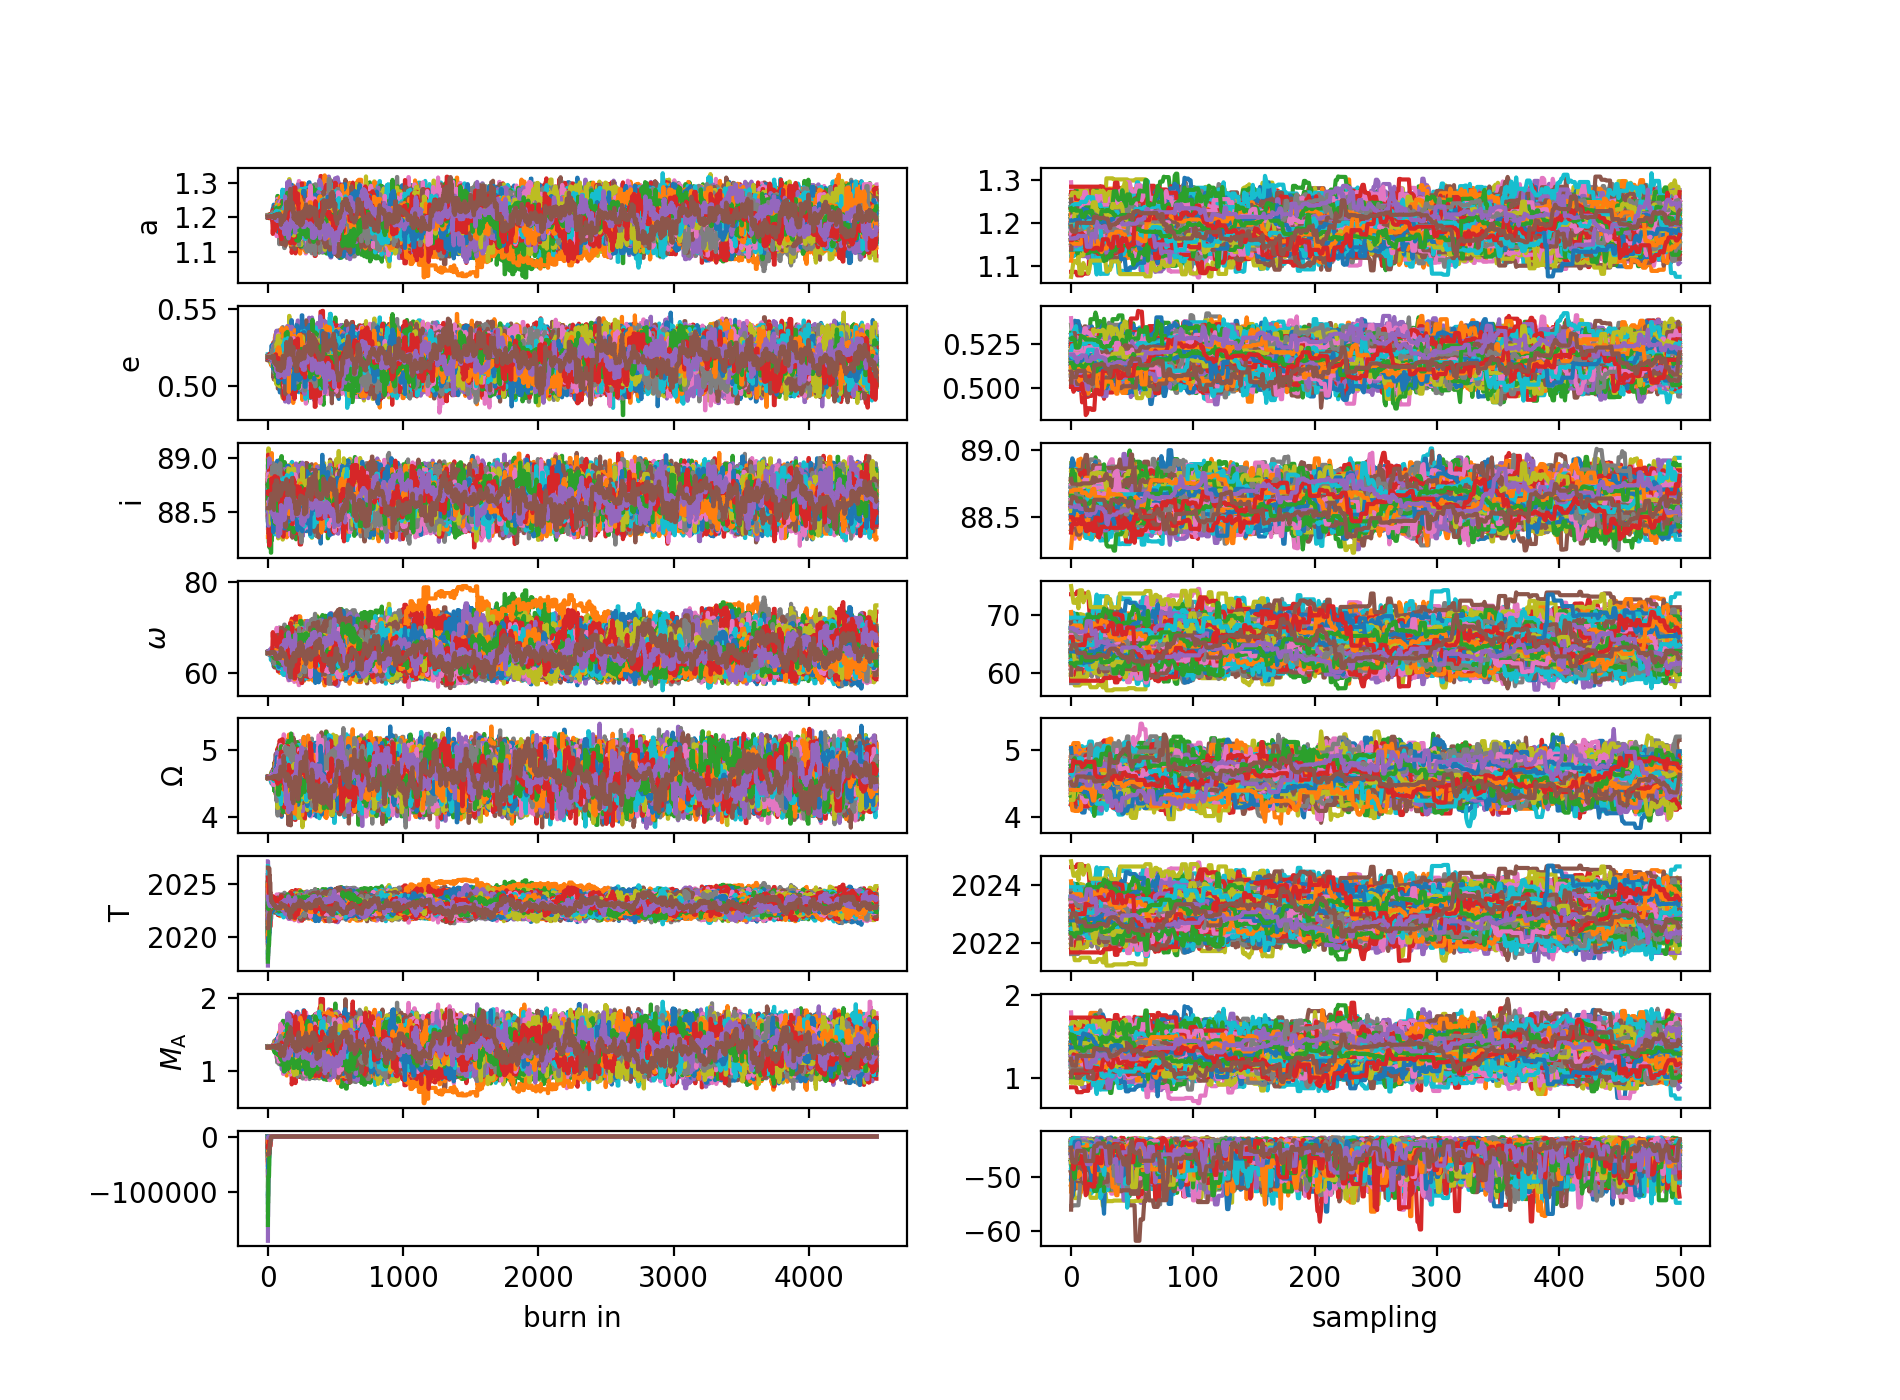

In [9]:
# see what the chains look like, skip a burn in period if desired
burn = 4500
fig,ax = plt.subplots(ndim+1,2,figsize=(9.5,7),sharex='col',sharey=False)

for j in range(nwalkers):
    ax[-1,0].plot(sampler.lnprobability[j,:burn])
    for i in range(ndim):
        ax[i,0].plot(sampler.chain[j,:burn,i])
        ax[i,0].set_ylabel(labels[i])

for j in range(nwalkers):
    ax[-1,1].plot(sampler.lnprobability[j,burn:])
    for i in range(ndim):
        ax[i,1].plot(sampler.chain[j,burn:,i])
#         ax[i,1].set_ylabel(ii.params[i])

ax[-1,0].set_xlabel('burn in')
ax[-1,1].set_xlabel('sampling')

fig.savefig('ab_orbit_chains.pdf')

In [10]:
sampler.get_autocorr_time(c=2)

array([362.74609951, 311.80923976, 268.6550801 , 284.3988156 ,
        87.95514807, 274.33994114, 330.71465405])

In [11]:
# get the best fit parameters
i = np.unravel_index(np.argmax(sampler.lnprobability), sampler.lnprobability.shape)
par = sampler.chain[i]
par = np.median(sampler.chain[:,burn:,:].reshape((-1,ndim)),axis=0)
s = np.std(sampler.chain[:,burn:,:].reshape((-1,ndim)),axis=0)
print(par)
print(s)

[1.19887735e+00 5.17233679e-01 8.86268715e+01 6.46651079e+01
 4.60345891e+00 2.02300118e+03 1.31284352e+00]
[0.03340585 0.00717832 0.09982203 2.37611372 0.17864611 0.47755406
 0.149504  ]


<IPython.core.display.Javascript object>


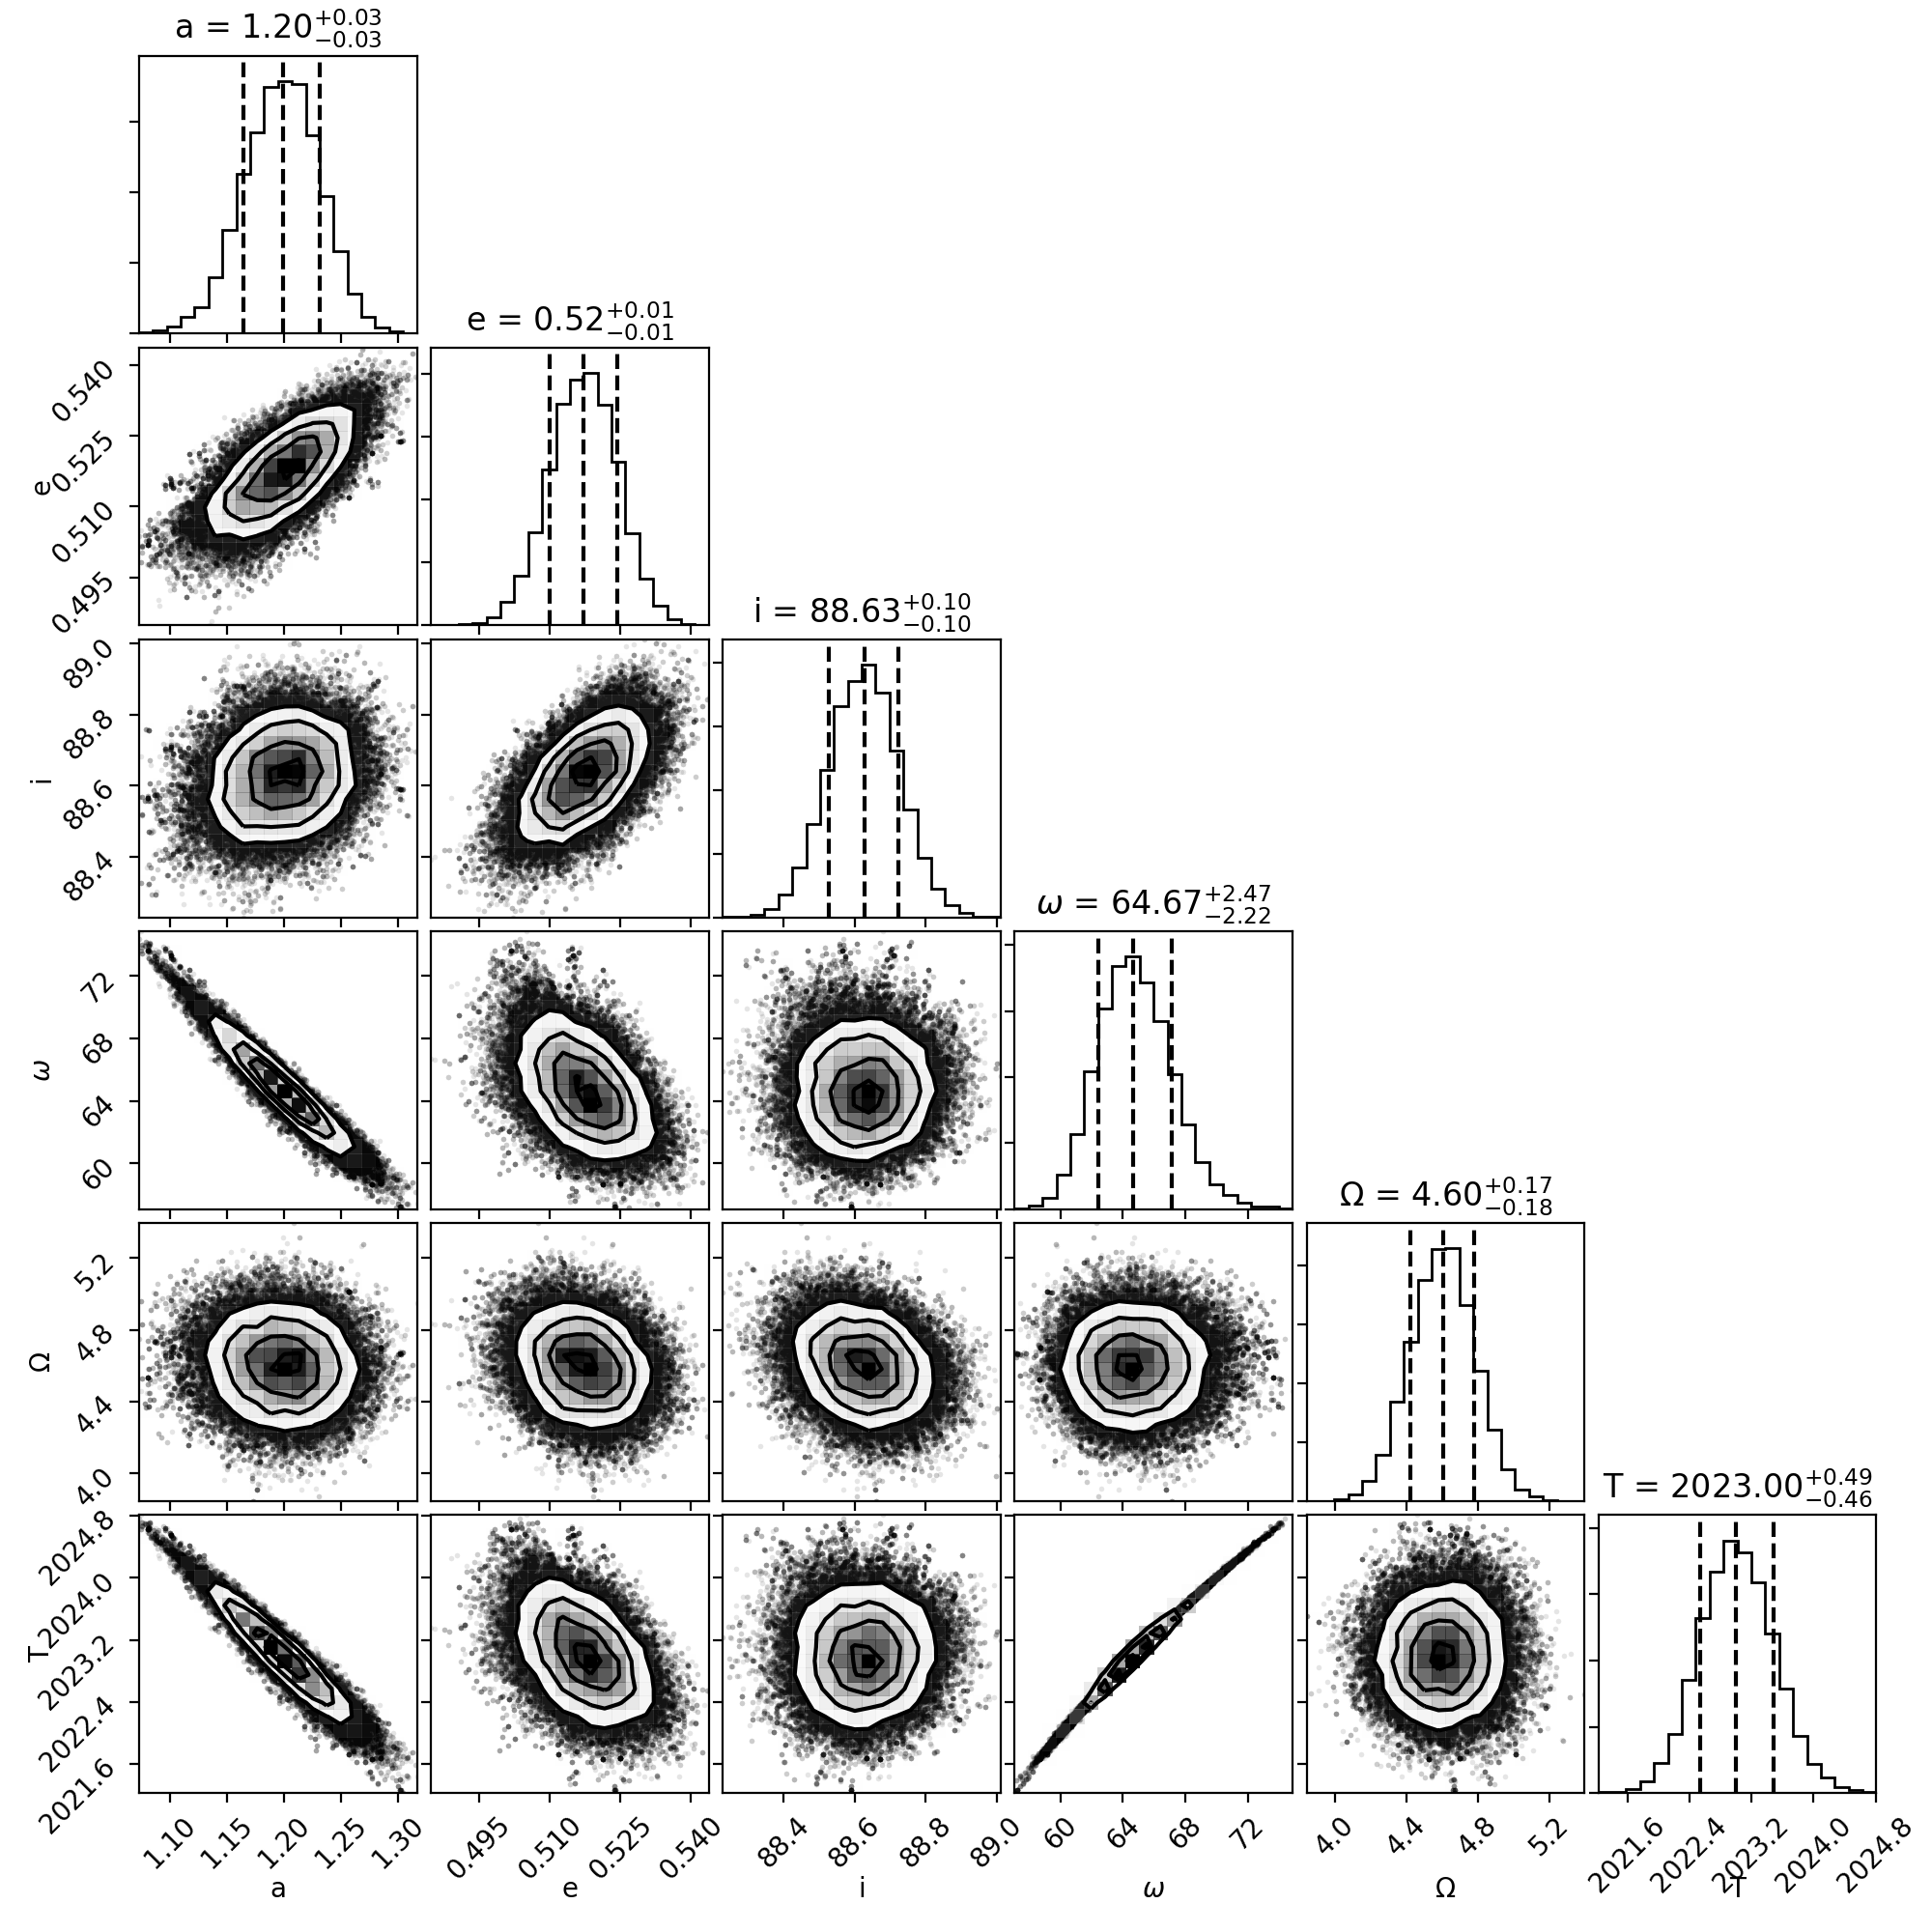

In [12]:
# make the corner plot
fig, ax = plt.subplots(6, 6, figsize=(10,10))
fig = corner.corner(sampler.chain[:,burn:,:-1].reshape((-1,ndim-1)), labels=labels[:-1], fig=fig,
                    show_titles=True, quantiles=(.16,.5,.84))#, truths=p0_tok)
fig.savefig('ab_orbit_corner.pdf')

<IPython.core.display.Javascript object>


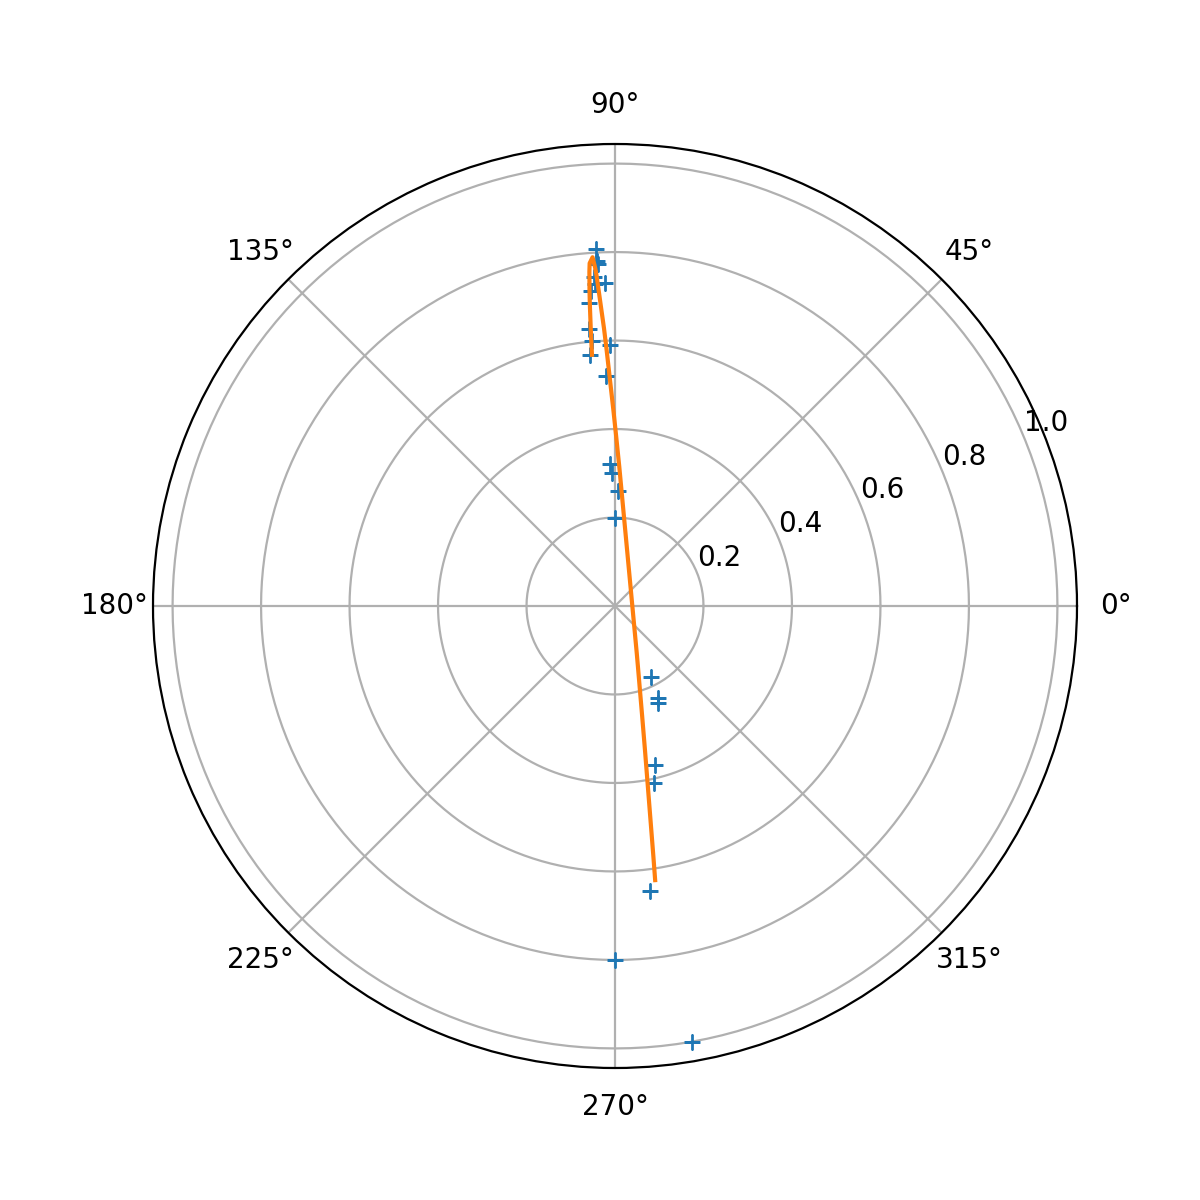

In [13]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(projection='polar')

ax.plot(np.deg2rad(pa), sep, '+')

mod_pa, mod_sep = orbit_pos(par)
ax.plot(np.deg2rad(mod_pa), mod_sep, '-')

fig.savefig('ab_orbit_orbit.pdf')

<IPython.core.display.Javascript object>


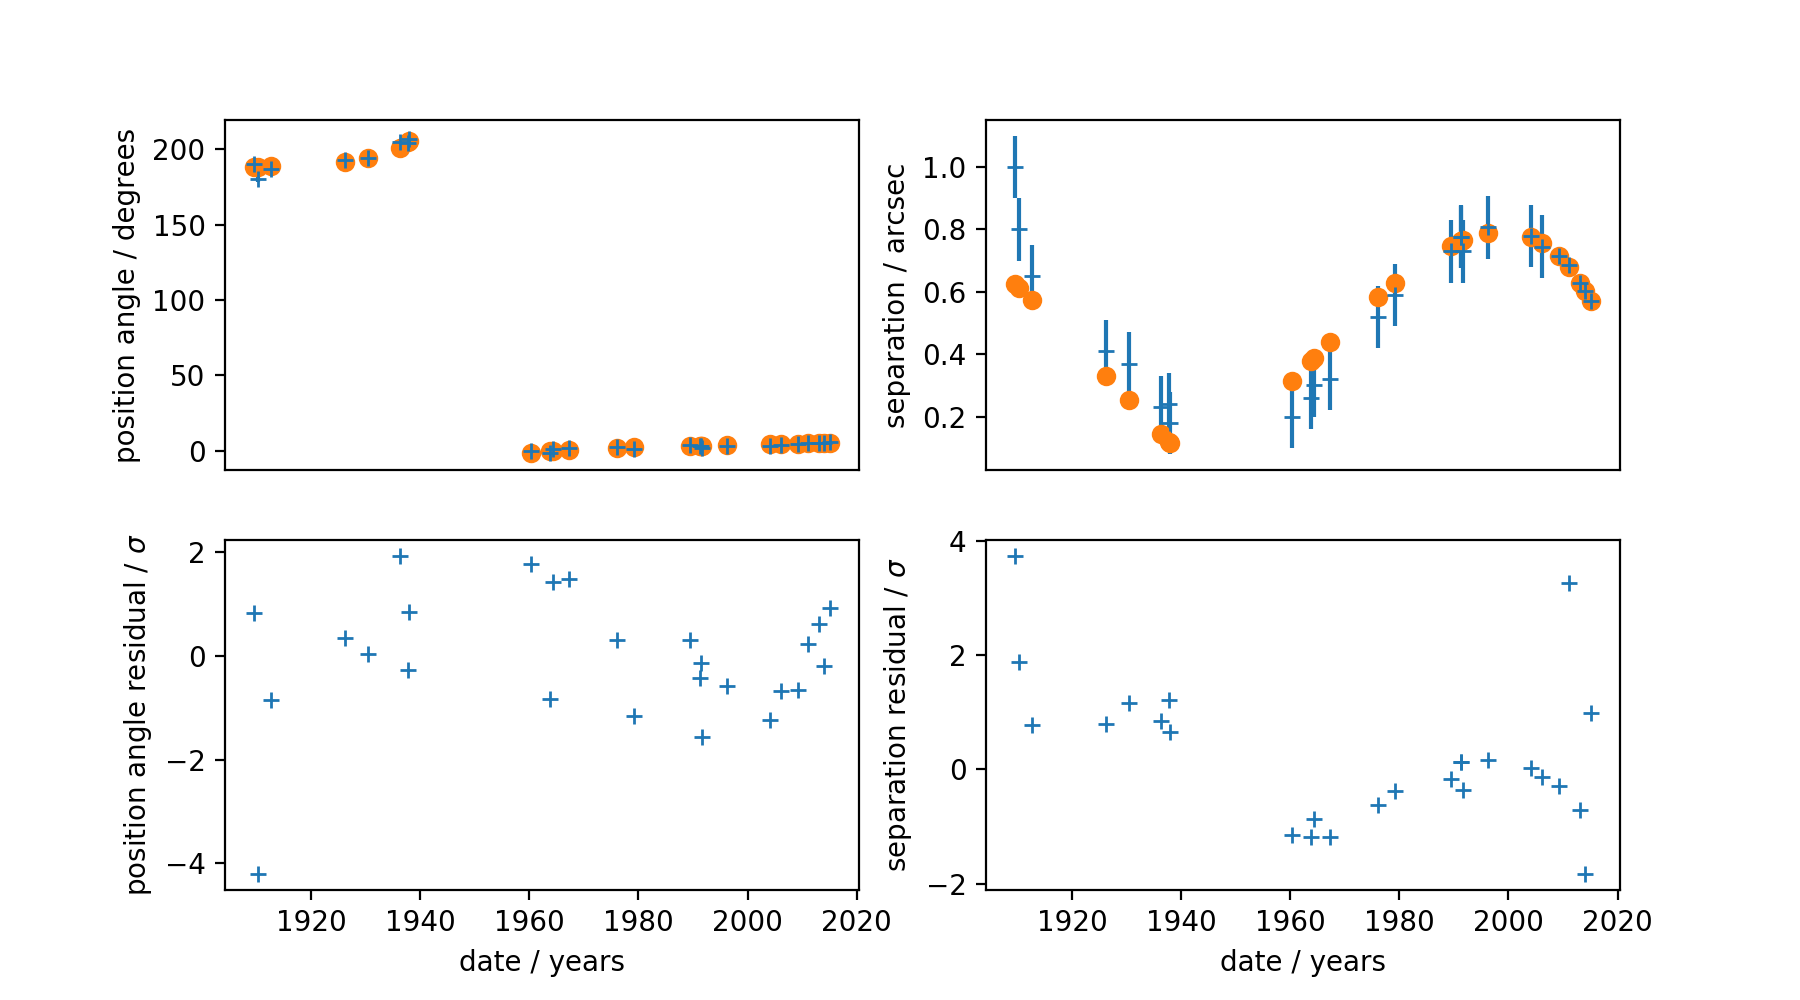

In [14]:
fig, ax = plt.subplots(2,2, figsize=(9,5), sharex=True)
ax[0,0].errorbar(date, pa-90, yerr=e_pa, fmt='+')
ax[0,0].plot(date, mod_pa-90, 'o')
ax[0,0].get_xaxis().set_visible(False)
ax[1,0].plot(date, (pa-mod_pa)/e_pa, '+')
ax[0,1].errorbar(date, sep, yerr=e_sep, fmt='+')
ax[0,1].plot(date, mod_sep, 'o')
ax[0,1].get_xaxis().set_visible(False)
ax[1,1].plot(date, (sep-mod_sep)/e_sep, '+')

ax[0,0].set_ylabel('position angle / degrees')
ax[1,0].set_ylabel('position angle residual / $\sigma$')
ax[1,0].set_xlabel('date / years')
ax[0,1].set_ylabel('separation / arcsec')
ax[1,1].set_ylabel('separation residual / $\sigma$')
ax[1,1].set_xlabel('date / years')

fig.savefig('ab_orbit_residual.pdf')

In [15]:
# take a look at how close the RV is to reality
lnlike(par, verb=True)

period:245.26946836965354
true anomaly:[-110.44877271 -105.242764  ]
vz(b):[7014.94185325 7489.54575214]
drv(1996, expect 7.02):7.014941853253974, dr(96-17, expect -0.63):-0.4746038988875507
40.11378440320536 43.91791338243702 0.0008643529900112652 0.6615876230397477


-42.350740572076056

In [16]:
period_dist = (sampler.chain[:,burn:,0]*44.9)**1.5 / np.sqrt(1.3+1.28)
pc = np.percentile(period_dist, (16,50,84))
print('{} + {} - {}'.format(pc[1], pc[2]-pc[1], pc[1]-pc[0]))

245.87919968496874 + 9.970397002919896 - 10.472548945940787


In [17]:
chain = sampler.chain
med = np.percentile(chain[:,burn:,:].reshape((-1,ndim)), 50, axis=0)
lo = med - np.percentile(chain[:,burn:,:].reshape((-1,ndim)), 16, axis=0)
hi = np.percentile(chain[:,burn:,:].reshape((-1,ndim)), 84, axis=0) - med
   
# latex
for pn,m,l,h in zip(labels,med,lo,hi):
    print('{} & {:g} & {:g} \\\\'.format(pn,m,(l+h)/2.))

a & 1.19888 & 0.0332414 \\
e & 0.517234 & 0.00710751 \\
i & 88.6269 & 0.0988616 \\
$\omega$ & 64.6651 & 2.34541 \\
$\Omega$ & 4.60346 & 0.177831 \\
T & 2023 & 0.474731 \\
$M_{\rm A}$ & 1.31284 & 0.148763 \\
